In [2]:
#importing the libraries
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Path to the dataset
dataset_path = 'C:\\Users\\naga2\\Downloads\\DM_final\\genres'

# Listing genres by reading folder names in the dataset path
genres = [name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))]
print("Genres:", genres)

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
# Creating a list to hold the audio data and labels
audio_data = []
labels = []

In [5]:
# Function for extracting the features
def extract_features(y, sr):
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_var = np.var(mfccs, axis=1)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_var = np.var(chroma, axis=1)
        mel_mean = np.mean(mel, axis=1)
        mel_var = np.var(mel, axis=1)
        features = np.hstack([mfccs_mean, mfccs_var, chroma_mean, chroma_var, mel_mean, mel_var])
        return features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

In [6]:
# Loading the dataset and extracting the features
for genre in genres:
    genre_path = os.path.join(dataset_path, genre)
    for filename in os.listdir(genre_path):
        if filename.endswith('.au'):
            file_path = os.path.join(genre_path, filename)
            y, sr = librosa.load(file_path, sr=None)
            features = extract_features(y, sr)
            audio_data.append(features)
            labels.append(genre)


In [7]:
# Converting to a DataFrame
features_df = pd.DataFrame(audio_data)
features_df['label'] = labels
print(features_df.head())

            0           1          2          3          4          5  \
0 -113.598824  121.570671 -19.162262  42.363937  -6.362266  18.621931   
1 -207.523834  123.985138   8.947019  35.867149   2.909595  21.519472   
2  -90.757164  140.440872 -29.084547  31.686693 -13.976547  25.753752   
3 -199.575134  150.086105   5.663404  26.855282   1.770071  14.232647   
4 -160.354172  126.209480 -35.581394  22.139257 -32.473549  10.850701   

           6          7          8          9  ...       297       298  \
0 -13.699734  15.339802 -12.274305  10.970945  ...  0.000587  0.000656   
1  -8.556513  23.370676 -10.103608  11.899242  ...  0.000415  0.000448   
2 -13.664990  11.634442 -11.778322   9.714756  ...  0.000039  0.000009   
3  -4.827845   9.286853  -0.756120   8.134435  ...  0.000014  0.000004   
4 -23.350071   0.493249 -11.796538   1.203519  ...  0.000016  0.000001   

            299           300           301           302           303  \
0  1.197972e-05  7.660740e-07  8.922267e-

In [8]:
# Encoding labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(features_df['label'])

# Scaling the features
scaler = StandardScaler()
X = scaler.fit_transform(features_df.drop(columns=['label']))

In [9]:
# Splitting the dataset into training, validation, and test sets (60% train, 20% val, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [10]:
# Building the model using Functional API
input_shape = (X_train.shape[1],)
inputs = layers.Input(shape=input_shape)

A = layers.Dense(256, activation='relu')(inputs)
B = layers.Dropout(0.5)(A)
C = layers.Dense(128, activation='relu')(B)
D = layers.Dropout(0.5)(C)
E = layers.Dense(64, activation='relu')(D)
F = layers.Dropout(0.5)(E)

output = layers.Dense(len(genres), activation='softmax')(F)

model = models.Model(inputs, output)


In [11]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0954 - loss: 3.3975 - val_accuracy: 0.2200 - val_loss: 2.2365
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1811 - loss: 2.5603 - val_accuracy: 0.2900 - val_loss: 2.1080
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1925 - loss: 2.3023 - val_accuracy: 0.3600 - val_loss: 2.0300
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1741 - loss: 2.3847 - val_accuracy: 0.3700 - val_loss: 1.9874
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2806 - loss: 2.1659 - val_accuracy: 0.3900 - val_loss: 1.9395
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2357 - loss: 2.0806 - val_accuracy: 0.3800 - val_loss: 1.9001
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2454 - loss: 2.0889 - val_accuracy: 0.3900 - val_loss: 1.8515
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2545 - loss: 2.0148 - val_accuracy: 0.4000 - val

In [16]:
# Evaluating the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

Validation Loss: 1.0207194089889526, Validation Accuracy: 0.6700000166893005


In [17]:
# Predicting the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Test Loss: 0.8856105208396912, Test Accuracy: 0.7200000286102295


In [19]:
# Generating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 6  0  0  0  0  1  0  0  1  1]
 [ 0  9  1  0  0  4  0  0  0  0]
 [ 0  0  5  2  0  0  0  0  0  0]
 [ 0  0  2  2  0  0  0  3  0  0]
 [ 0  0  0  0  8  0  0  2  1  0]
 [ 0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  0  1  1  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0 11  0]
 [ 1  0  2  1  0  1  1  0  2  7]]


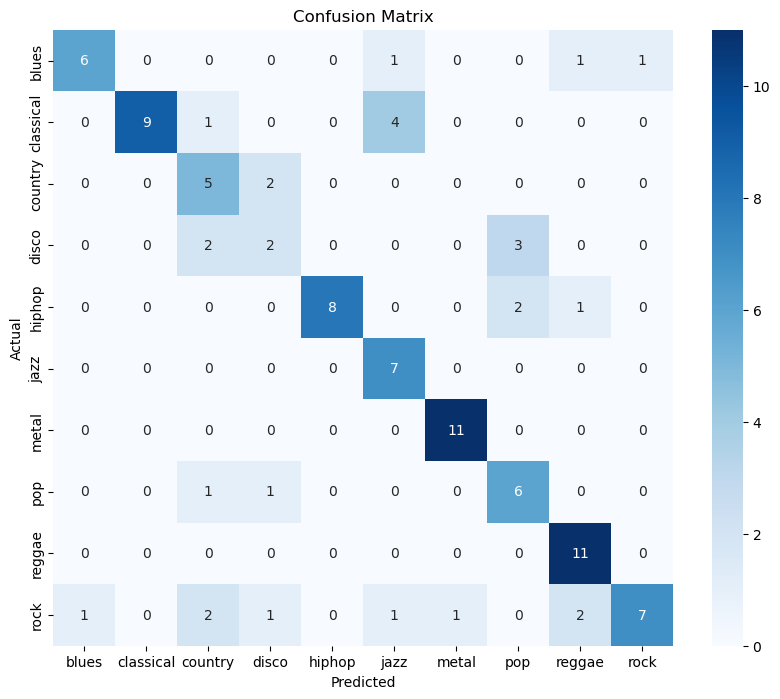

In [20]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# classification report
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.67      0.75         9
   classical       1.00      0.64      0.78        14
     country       0.45      0.71      0.56         7
       disco       0.33      0.29      0.31         7
      hiphop       1.00      0.73      0.84        11
        jazz       0.54      1.00      0.70         7
       metal       0.92      1.00      0.96        11
         pop       0.55      0.75      0.63         8
      reggae       0.73      1.00      0.85        11
        rock       0.88      0.47      0.61        15

    accuracy                           0.72       100
   macro avg       0.73      0.73      0.70       100
weighted avg       0.78      0.72      0.72       100



In [23]:
# Function to predict the genre of an input audio file
def predict_genre(audio_path, model, scaler, label_encoder):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        features = extract_features(y, sr)
        if features is not None:
            features_scaled = scaler.transform([features])
            prediction = model.predict(features_scaled)
            predicted_genre = label_encoder.inverse_transform([np.argmax(prediction)])
            return predicted_genre[0]
        else:
            return "Error: Could not extract features from the audio file"
    except Exception as e:
        return f"Error: {e}"


audio_path = 'C:\\Users\\naga2\\Downloads\\DM_final\\test\\test4.au' #this is a reggae file
predicted_genre = predict_genre(audio_path, model, scaler, label_encoder)
print(f"The predicted genre for the provided audio file is: {predicted_genre}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
The predicted genre for the provided audio file is: reggae
